<a href="https://colab.research.google.com/github/AndrGutierrez/CatsAndDogs/blob/main/11_DataAugmentation_y_TransferLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 11. *Data Augmentation* y *Transfer Learning*
[**Python Deep Learning** Introducción práctica con Keras y TensorFlow 2. Jordi Torres. Editorial Marcombo ISBN: 9788426728289 ](https://www.marcombo.com/python-deep-learning-9788426728289/)


In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras

print(tf.__version__)

2.1.0-rc1



## Datos


In [7]:
from google.colab import files
# se debe cargar el fichero “cats_and_dogs_small.zip”
uploaded = files.upload()

In [2]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
# uploaded = drive.CreateFile({'title': 'Sample upload.txt'})
# uploaded.SetContentString('Sample upload file content')
# uploaded.Upload()
# print('Uploaded file with ID {}'.format(uploaded.get('id')))

# Get Cats and dogs from my personal google drive

In [3]:
from googleapiclient.discovery import build
import io
from googleapiclient.http import MediaIoBaseDownload

drive_service = build('drive', 'v3')

file_list = drive.ListFile({'q': "title contains 'cats_and_dogs_small' and trashed=false"}).GetList()
# for file in file_list:
#   print(file['title'], file['id'])# print(file_list[0]['title']) # should be the title of the file we just created
file_id = file_list[0]['id'] # get the file ID
print(f'File id: {file_id}')

request = drive_service.files().get_media(fileId=file_id)
downloaded = io.BytesIO()
downloader = MediaIoBaseDownload(downloaded, request)
done = False
while done is False:
  # _ is a placeholder for a progress object that we ignore.
  # (Our file is small, so we skip reporting progress.)
  _, done = downloader.next_chunk()

# downloaded.seek(0)
# print('Downloaded file contents are: {}'.format(downloaded.read()))

File id: 1UmiVz4_4hIk9XlOH1XGeViavsyY35j0c


In [4]:
import os
import zipfile

local_zip = '/content/cats_and_dogs_small.zip'

# zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref = zipfile.ZipFile(downloaded, 'r')
zip_ref.extractall('/content')
zip_ref.close()


In [5]:

base_dir = '/content/cats_and_dogs_small'

train_dir =      os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir =       os.path.join(base_dir, 'test')

# Directorio con las imagenes de training 
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directorio con las imagenes de validation
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

# Directorio con las imagenes de test
test_cats_dir = os.path.join(test_dir, 'cats')
test_dogs_dir = os.path.join(test_dir, 'dogs')



In [6]:
print('total training cat images :', len(os.listdir(train_cats_dir ) ))
print('total training dog images :', len(os.listdir(train_dogs_dir ) ))

print('total validation cat images :', len(os.listdir( validation_cats_dir ) ))
print('total validation dog images :', len(os.listdir( validation_dogs_dir ) ))

print('total test cat images :', len(os.listdir( test_cats_dir ) ))
print('total test dog images :', len(os.listdir( test_dogs_dir ) ))


total training cat images : 1000
total training dog images : 1000
total validation cat images : 500
total validation dog images : 500
total test cat images : 500
total test dog images : 500


Saving Wiliams-foto1.jpg to Wiliams-foto1.jpg


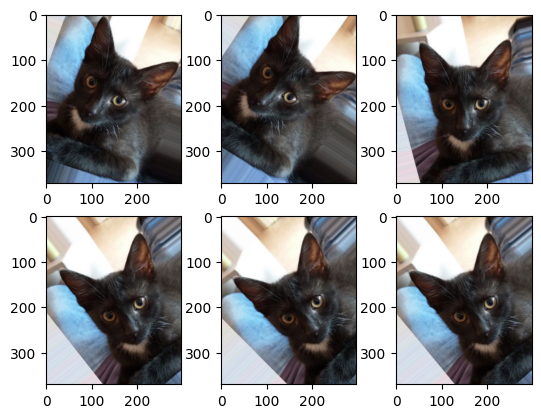

In [7]:
from numpy import expand_dims
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot

from google.colab import files
from tensorflow.keras.preprocessing import image
 
uploaded=files.upload()
for fn in uploaded.keys():
  path='/content/' + fn
  img=image.load_img(path)
  data = img_to_array(img)
  samples = expand_dims(data, 0)
  
  # example of "rotation_range"
  datagen = ImageDataGenerator(rotation_range=45)

  it = datagen.flow(samples, batch_size=1)
  for i in range(6):
  	pyplot.subplot(230 + 1 + i)
  	batch = it.next()
  	image = batch[0].astype('uint8')
  	pyplot.imshow(image)
pyplot.show()

### ModelDA: Modelo con *Data Augmentation*

In [8]:
from tensorflow.keras import Model

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

modelDA = Sequential()
modelDA.add(Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)))
modelDA.add(MaxPooling2D(2, 2))
modelDA.add(Conv2D(64, (3,3), activation='relu'))
modelDA.add(MaxPooling2D(2,2))
modelDA.add(Conv2D(128, (3,3), activation='relu'))
modelDA.add(MaxPooling2D(2,2))
modelDA.add(Conv2D(128, (3,3), activation='relu'))
modelDA.add(MaxPooling2D(2,2))
modelDA.add(Flatten())
modelDA.add(Dense(512, activation='relu'))
modelDA.add(Dense(1, activation='sigmoid'))

from tensorflow.keras.optimizers import RMSprop

modelDA.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=1e-4),
              metrics=['acc'])



In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

validation_datagen  = ImageDataGenerator( rescale = 1.0/255. )
test_datagen  = ImageDataGenerator( rescale = 1.0/255. )


train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=20,
                                                    class_mode='binary',
                                                    target_size=(150, 150))     

validation_generator =  validation_datagen.flow_from_directory(validation_dir,
                                                         batch_size=20,
                                                         class_mode  = 'binary',
                                                         target_size = (150, 150))


test_generator =  test_datagen.flow_from_directory(validation_dir,
                                                         batch_size=20,
                                                         class_mode  = 'binary',
                                                         target_size = (150, 150))


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [10]:
batch_size = 20
steps_per_epoch = train_generator.n // batch_size
validation_steps = validation_generator.n // batch_size

historyDA = modelDA.fit(
      train_generator,
      steps_per_epoch= steps_per_epoch,
      epochs= 50,
      validation_data= validation_generator,
      validation_steps= validation_steps,
      verbose=2)

Epoch 1/50
100/100 - 30s - loss: 0.7057 - acc: 0.5135 - val_loss: 0.6857 - val_acc: 0.5610 - 30s/epoch - 302ms/step
Epoch 2/50
100/100 - 23s - loss: 0.6971 - acc: 0.5410 - val_loss: 0.6841 - val_acc: 0.5710 - 23s/epoch - 227ms/step
Epoch 3/50
100/100 - 18s - loss: 0.6914 - acc: 0.5565 - val_loss: 0.6807 - val_acc: 0.5780 - 18s/epoch - 182ms/step
Epoch 4/50
100/100 - 18s - loss: 0.6848 - acc: 0.5775 - val_loss: 0.6711 - val_acc: 0.5920 - 18s/epoch - 182ms/step
Epoch 5/50
100/100 - 19s - loss: 0.6828 - acc: 0.5605 - val_loss: 0.6734 - val_acc: 0.5600 - 19s/epoch - 192ms/step
Epoch 6/50
100/100 - 18s - loss: 0.6677 - acc: 0.6120 - val_loss: 0.6540 - val_acc: 0.6360 - 18s/epoch - 183ms/step
Epoch 7/50
100/100 - 19s - loss: 0.6626 - acc: 0.6120 - val_loss: 0.6544 - val_acc: 0.6050 - 19s/epoch - 191ms/step
Epoch 8/50
100/100 - 18s - loss: 0.6534 - acc: 0.6400 - val_loss: 0.6103 - val_acc: 0.6470 - 18s/epoch - 182ms/step
Epoch 9/50
100/100 - 19s - loss: 0.6319 - acc: 0.6430 - val_loss: 0.5818

In [11]:
print (steps_per_epoch)
print (validation_steps)
test_lost, test_acc= modelDA.evaluate(test_generator)
print ("Test Accuracy:", test_acc)

100
50
50/50 [==============================] - 3s 66ms/step - loss: 0.4495 - acc: 0.7900
Test Accuracy: 0.7900000214576721


Saving Catire.jpeg to Catire (3).jpeg
1/1 [==============================] - 0s 21ms/step
[[0.00179407]]


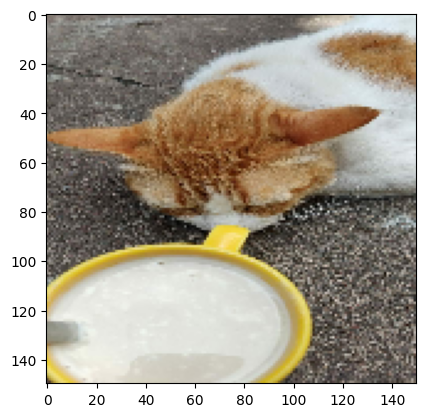

Catire.jpeg IS A DOG


In [15]:
import numpy as np

from google.colab import files
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
uploaded=files.upload()
file=list(uploaded.keys())[0]

path='/content/' + file
img=image.load_img(path, target_size=(150, 150))

x=image.img_to_array(img)
image=np.expand_dims(x, axis=0)  

classes = modelDA.predict(image)
print(classes)

plt.imshow(img)
plt.show()

if classes>0: print( file + " IS A DOG")
else: print( file + " IS A CAT")

No handles with labels found to put in legend.


<Figure size 432x288 with 0 Axes>

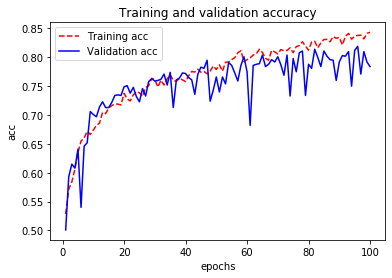

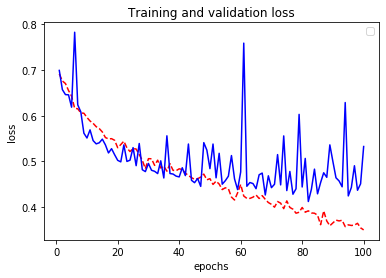

<Figure size 432x288 with 0 Axes>

In [ ]:

import matplotlib.pyplot as plt


acc      = historyDA.history[     'acc' ]
val_acc  = historyDA.history[ 'val_acc' ]
loss     = historyDA.history[    'loss' ]
val_loss = historyDA.history['val_loss' ]

epochs    = range(1,len(acc)+1,1) # obtener número de epochs

plt.plot  ( epochs,     acc, 'r--', label='Training acc'  )
plt.plot  ( epochs, val_acc,  'b', label='Validation acc')
plt.title ('Training and validation accuracy')
plt.ylabel('acc')
plt.xlabel('epochs')

plt.legend()
plt.figure()


plt.plot  ( epochs,     loss, 'r--' )
plt.plot  ( epochs, val_loss ,  'b' )
plt.title ('Training and validation loss'   )
plt.ylabel('loss')
plt.xlabel('epochs')

plt.legend()
plt.figure()



### ModelFE: Modelo con *Feature Extraction*

In [22]:

from tensorflow.keras.applications import VGG16

pre_trained_model = VGG16(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = 'imagenet')


pre_trained_model.summary()

for layer in pre_trained_model.layers:
  layer.trainable = False


pre_trained_model.summary()




58889256/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                              

In [23]:
from tensorflow.keras import Model

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

modelFE = Sequential()
modelFE.add(pre_trained_model)
modelFE.add(Flatten())
modelFE.add(Dense(256, activation='relu'))
modelFE.add(Dense(1, activation='sigmoid'))


In [24]:
modelFE.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 dense_2 (Dense)             (None, 256)               2097408   
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________


In [25]:

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

validation_datagen  = ImageDataGenerator( rescale = 1.0/255. )
test_datagen  = ImageDataGenerator( rescale = 1.0/255. )


train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=20,
                                                    class_mode='binary',
                                                    target_size=(150, 150))     

validation_generator =  validation_datagen.flow_from_directory(validation_dir,
                                                         batch_size=20,
                                                         class_mode  = 'binary',
                                                         target_size = (150, 150))

test_generator =  test_datagen.flow_from_directory(validation_dir,
                                                         batch_size=20,
                                                         class_mode  = 'binary',
                                                         target_size = (150, 150))





Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [27]:
from tensorflow.keras.optimizers import RMSprop

modelFE.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=1e-4),
              metrics=['acc'])

batch_size = 20
steps_per_epoch = train_generator.n // batch_size
validation_steps = validation_generator.n // batch_size

historyFE = modelFE.fit(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = steps_per_epoch,
            epochs = 50,
            validation_steps = validation_steps,
            verbose = 2)



Epoch 1/50
100/100 - 22s - loss: 0.3014 - acc: 0.8710 - val_loss: 0.2785 - val_acc: 0.8860 - 22s/epoch - 223ms/step
Epoch 2/50
100/100 - 20s - loss: 0.2780 - acc: 0.8780 - val_loss: 0.3374 - val_acc: 0.8660 - 20s/epoch - 203ms/step
Epoch 3/50
100/100 - 20s - loss: 0.2788 - acc: 0.8765 - val_loss: 0.2402 - val_acc: 0.9020 - 20s/epoch - 204ms/step
Epoch 4/50
100/100 - 22s - loss: 0.2916 - acc: 0.8675 - val_loss: 0.2430 - val_acc: 0.9010 - 22s/epoch - 216ms/step
Epoch 5/50
100/100 - 31s - loss: 0.2968 - acc: 0.8750 - val_loss: 0.2624 - val_acc: 0.8960 - 31s/epoch - 312ms/step
Epoch 6/50
100/100 - 21s - loss: 0.2774 - acc: 0.8820 - val_loss: 0.2646 - val_acc: 0.8950 - 21s/epoch - 211ms/step
Epoch 7/50
100/100 - 20s - loss: 0.2818 - acc: 0.8790 - val_loss: 0.3225 - val_acc: 0.8680 - 20s/epoch - 196ms/step
Epoch 8/50
100/100 - 20s - loss: 0.2802 - acc: 0.8725 - val_loss: 0.2569 - val_acc: 0.9010 - 20s/epoch - 203ms/step
Epoch 9/50
100/100 - 21s - loss: 0.2726 - acc: 0.8805 - val_loss: 0.3251

In [29]:
test_lost, test_acc= modelFE.evaluate(test_generator)
print ("Test Accuracy:", test_acc)

50/50 [==============================] - 4s 72ms/step - loss: 0.3493 - acc: 0.8890
Test Accuracy: 0.8889999985694885


<Figure size 640x480 with 0 Axes>

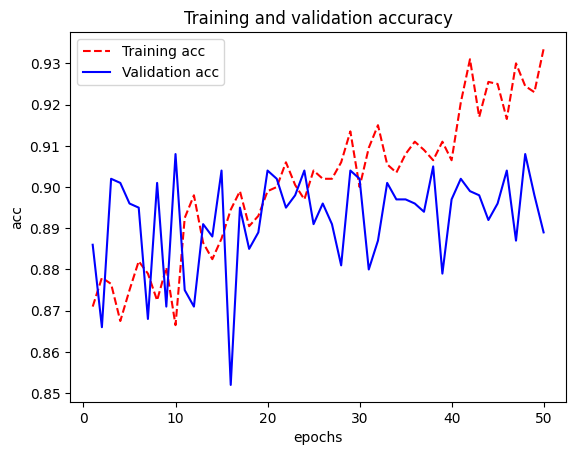

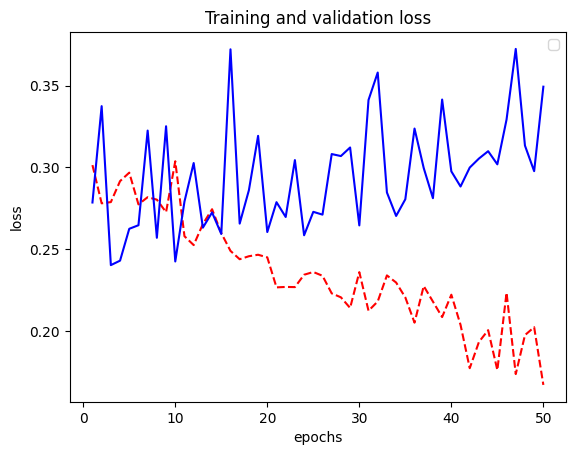

<Figure size 640x480 with 0 Axes>

In [30]:

import matplotlib.pyplot as plt


acc      = historyFE.history[     'acc' ]
val_acc  = historyFE.history[ 'val_acc' ]
loss     = historyFE.history[    'loss' ]
val_loss = historyFE.history['val_loss' ]

epochs    = range(1,len(acc)+1,1) # obtener número de epochs

plt.plot  ( epochs,     acc, 'r--', label='Training acc'  )
plt.plot  ( epochs, val_acc,  'b', label='Validation acc')
plt.title ('Training and validation accuracy')
plt.ylabel('acc')
#plt.ylim(0,1)
plt.xlabel('epochs')

plt.legend()
plt.figure()


plt.plot  ( epochs,     loss, 'r--' )
plt.plot  ( epochs, val_loss ,  'b' )
plt.title ('Training and validation loss'   )
plt.ylabel('loss')
plt.xlabel('epochs')
#plt.ylim(0,1)

plt.legend()
plt.figure()




Saving Catire.jpeg to Catire (5).jpeg
1/1 [==============================] - 0s 18ms/step
[[1.]]


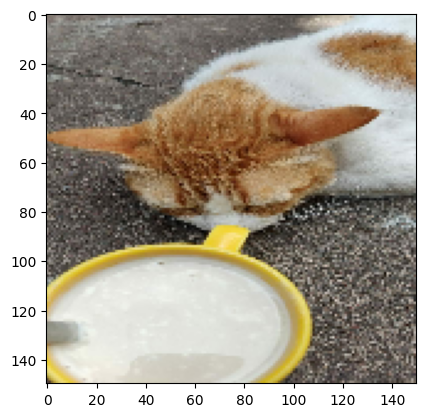

Catire.jpeg IS A DOG


In [34]:
import numpy as np

from google.colab import files
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
uploaded=files.upload()
file=list(uploaded.keys())[0]

path='/content/' + file
img=image.load_img(path, target_size=(150, 150))

x=image.img_to_array(img)
image=np.expand_dims(x, axis=0)  

classes = modelFE.predict(image)
print(classes)

plt.imshow(img)
plt.show()

if classes>0: print( file + " IS A DOG")
else: print( file + " IS A CAT")

### ModelFT : Modelo con *Fine Tuning*

In [36]:
from sys import set_coroutine_origin_tracking_depth
from tensorflow.keras.applications import VGG16

pre_trained_model= VGG16(input_shape=(150, 150, 3), 
                         include_top=False,
                         weights='imagenet')

pre_trained_model.trainable=True
set_trainable= False

for layer in pre_trained_model.layers:
  if layer.name=='blocks5_conv1':
    set_trainable==True
  if set_trainable:
    layer.trainable=True
  else:
    layer.trainable=False

modelFT= Sequential()
modelFT.add(pre_trained_model)
modelFT.add(Flatten())
modelFT.add(Dense(256, activation='relu'))
modelFT.add(Dense(1, activation='sigmoid'))

In [37]:
modelFT.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 8192)              0         
                                                                 
 dense_4 (Dense)             (None, 256)               2097408   
                                                                 
 dense_5 (Dense)             (None, 1)                 257       
                                                                 
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________


In [38]:
modelFT.compile(loss='binary_crossentropy',
                optimizer=RMSprop(learning_rate=1e-4),
                metrics=['acc'])

historyFT= modelFT.fit(
    train_generator,
    validation_data= validation_generator,
    steps_per_epoch= steps_per_epoch,
    epochs=50
)

Epoch 1/50
100/100 [==============================] - 23s 218ms/step - loss: 0.5297 - acc: 0.7220 - val_loss: 0.3074 - val_acc: 0.8810
Epoch 2/50
100/100 [==============================] - 21s 209ms/step - loss: 0.4229 - acc: 0.8090 - val_loss: 0.2732 - val_acc: 0.8920
Epoch 3/50
100/100 [==============================] - 21s 207ms/step - loss: 0.3751 - acc: 0.8265 - val_loss: 0.2713 - val_acc: 0.8860
Epoch 4/50
100/100 [==============================] - 22s 215ms/step - loss: 0.3965 - acc: 0.8295 - val_loss: 0.2641 - val_acc: 0.8860
Epoch 5/50
100/100 [==============================] - 21s 208ms/step - loss: 0.3567 - acc: 0.8345 - val_loss: 0.2535 - val_acc: 0.8960
Epoch 6/50
100/100 [==============================] - 21s 205ms/step - loss: 0.3312 - acc: 0.8480 - val_loss: 0.2480 - val_acc: 0.8990
Epoch 7/50
100/100 [==============================] - 20s 201ms/step - loss: 0.3188 - acc: 0.8575 - val_loss: 0.2593 - val_acc: 0.8950
Epoch 8/50
100/100 [==============================] - 2

In [50]:
test_loss, test_acc=modelFT.evaluate(test_generator)
print("Test Accuracy: ", test_acc)

50/50 [==============================] - 4s 77ms/step - loss: 0.4014 - acc: 0.8850
Test Accuracy:  0.8849999904632568


Saving candy.jpeg to candy (3).jpeg
1/1 [==============================] - 0s 20ms/step
[[1.]]


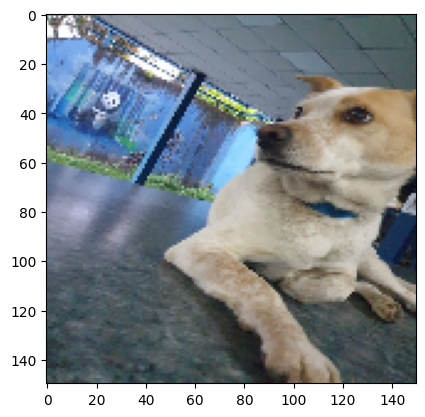

candy.jpeg IS A LADRONA DE AREPAS MALDITA SEA CANDY


In [65]:
import numpy as np

from google.colab import files
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
uploaded=files.upload()
file=list(uploaded.keys())[0]

path='/content/' + file
img=image.load_img(path, target_size=(150, 150))

x=image.img_to_array(img)
image=np.expand_dims(x, axis=0)  

classes = modelFT.predict(image)
print(classes)

plt.imshow(img)
plt.show()

if classes>0: print( file + " IS A DOG")
else: print( file + " IS A CAT")

<Figure size 640x480 with 0 Axes>

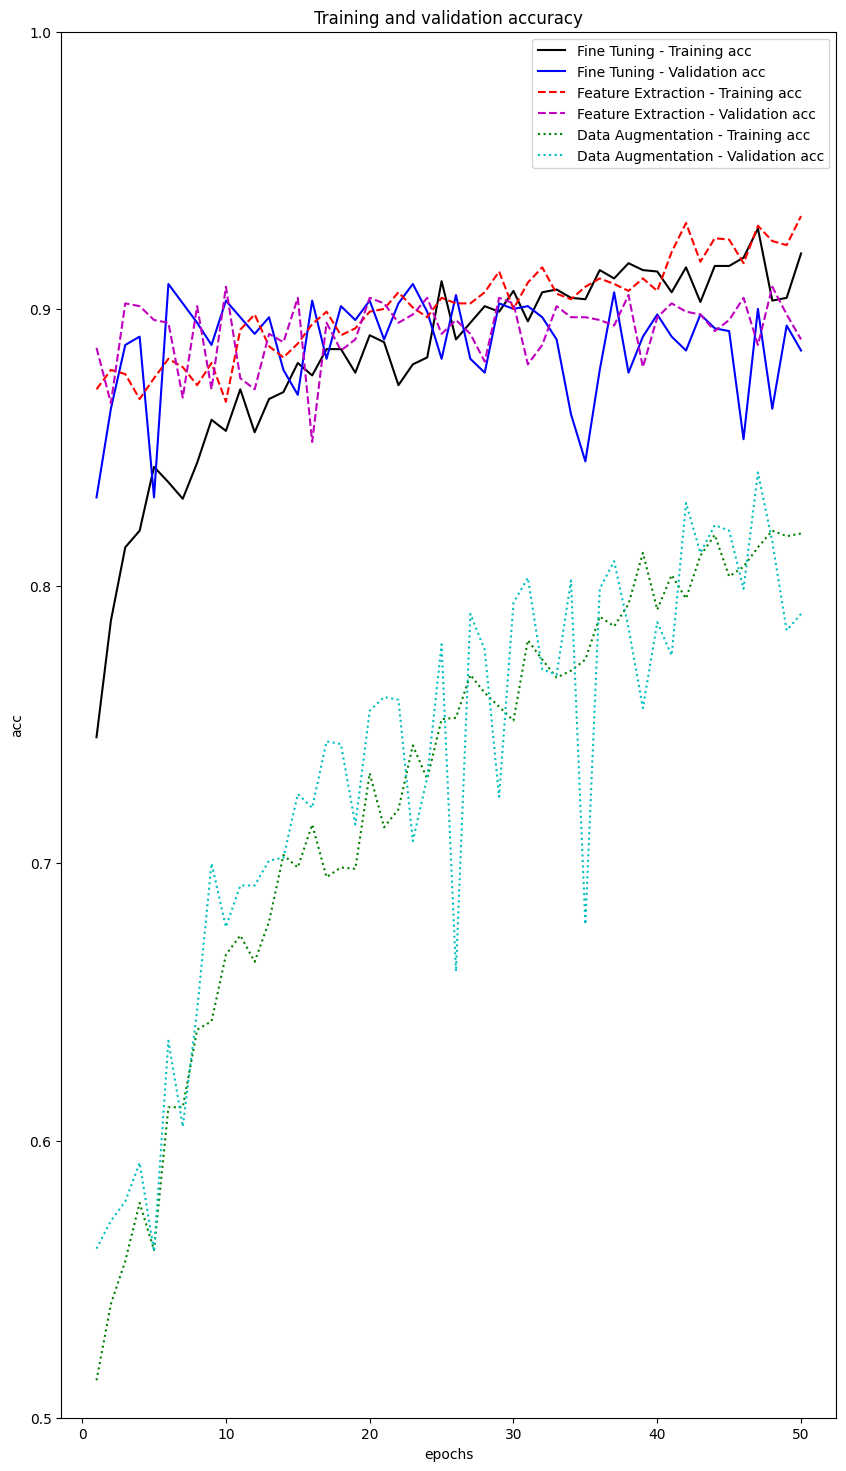

<Figure size 640x480 with 0 Axes>

In [62]:

accDA      = historyDA.history[     'acc' ]
val_accDA  = historyDA.history[ 'val_acc' ]

accFE      = historyFE.history[     'acc' ]
val_accFE  = historyFE.history[ 'val_acc' ]

accFT      = historyFT.history[     'acc' ]
val_accFT  = historyFT.history[ 'val_acc' ]

epochs    = range(1,len(accDA)+1,1) 

plt.figure(figsize=(10,18))

plt.plot  ( epochs,     accFT, 'k', label='Fine Tuning - Training acc '  )
plt.plot  ( epochs, val_accFT,  'b', label='Fine Tuning - Validation acc ')

plt.plot  ( epochs,     accFE, 'r--', label='Feature Extraction - Training acc'  )
plt.plot  ( epochs, val_accFE,  'm--', label='Feature Extraction - Validation acc')

plt.plot  ( epochs,     accDA, 'g:', label='Data Augmentation - Training acc'  )
plt.plot  ( epochs, val_accDA,  'c:', label='Data Augmentation - Validation acc')

plt.title ('Training and validation accuracy')
plt.ylabel('acc')
plt.ylim(0.5,1)
plt.xlabel('epochs')


plt.legend()
plt.figure()
